In [129]:
import sys
import os
import rasterio
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torch.nn as nn

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the root directory
root_directory = os.path.abspath(os.path.join(current_dir, '..'))

# Add the root directory to the system path
sys.path.append(root_directory)

# Verify the path addition
from helper_utils import *

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(data):
    """
    Plot a heatmap from a 2D NumPy array.

    :param data: 2D NumPy array representing the heatmap data.
    """
    plt.imshow(data, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()

def convert_backslashes_to_forward_slashes(path):
    """
    Converts all backslashes in the given path to forward slashes.

    :param path: The file path as a string.
    :return: The modified file path with forward slashes.
    """
    return path.replace('\\', '/')

def list_files_in_folder(folder_path):
    """
    Returns a list of paths to all files in the given folder.

    :param folder_path: Path to the folder.
    :return: List of file paths.
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [110]:
paths =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\PhC-C2DH-U373\01_ST'))
paths_imgs =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\PhC-C2DH-U373\01'))
paths_GT =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\PhC-C2DH-U373\01_GT\TRA'))

In [105]:
len(paths)

115

In [111]:
paths_GT = paths_GT[1:]
len(paths_GT)

115

In [108]:
paths_GT[0]

'C:/Users/Dell/Documents/Heidelberg_hackaton/CellTrackingU-Net/data/train/PhC-C2DH-U373/01_GT/TRA\\man_track000.tif'

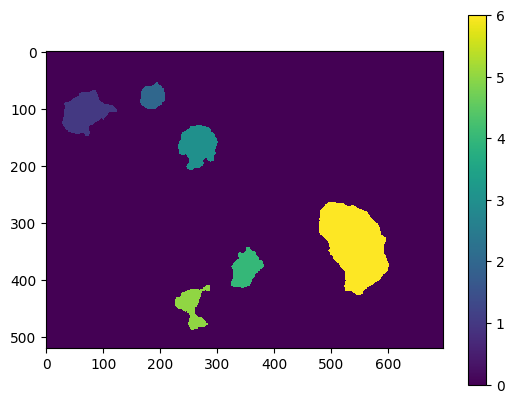

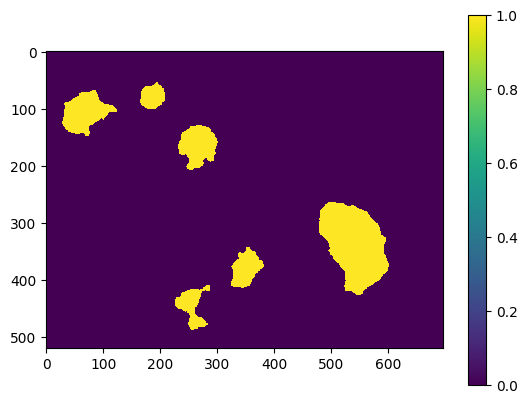

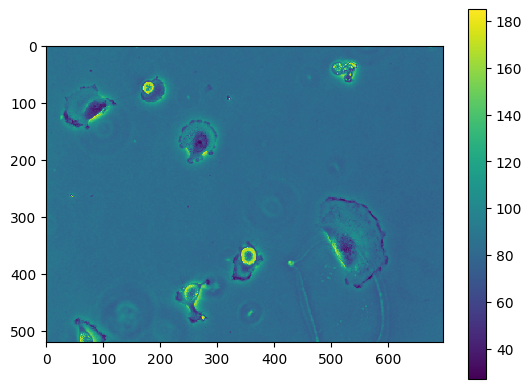

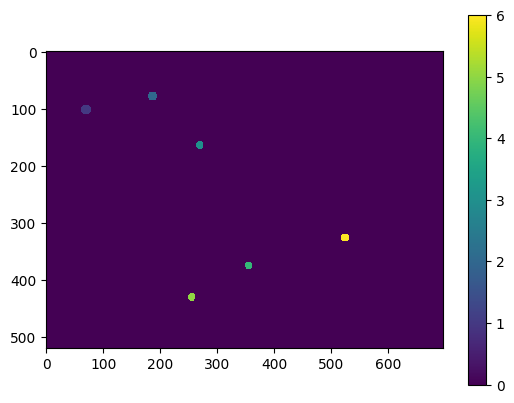

In [114]:
i = 6
image = Image.open(paths[i])
image_array = np.array(image)
image2 = Image.open(paths_imgs[i])
image_array2 = np.array(image2)
image3 = Image.open(paths_GT[i])
image_array3 = np.array(image3)
img = np.where(image_array != 0, 1, image_array)
plot_heatmap(image_array)
plot_heatmap(img)
plot_heatmap(image_array2)
plot_heatmap(image_array3)

In [115]:
class TIF_dataset(Dataset):

    def __init__(self, path_list_data, path_list_label, transform=None):
        """

        All of our data is in the same format. I sugest using the silver truths as they are in the format ideal for training.
        I dont understand how the golden truths are suposed to work, we need to look into that. (especialy in the file PhC-C2DH-U373)

        Arguments:
            path_list_data: list of paths to tif files that will be datapoints
            path_list_label: list of paths to tif files that will be labels
            transform (callable, optional): Optional transform to be applied
                on a sample.

        Returns : a pair of tensors of shape (1, W, H), coresponding to data and label
        """
        self.path_list_data = path_list_data
        self.path_list_label = path_list_label
        self.transform = transform

    def __len__(self):
        return len(self.path_list_data)

    def __getitem__(self, idx):
        image = Image.open(self.path_list_data[idx])
        image_np = np.array(image)
        label = Image.open(self.path_list_label[idx])
        label_np = np.array(label)
        label_np = np.where(label_np != 0, 1, label_np)

        image_tensor = torch.from_numpy(image_np).unsqueeze(0)
        label_tensor = torch.from_numpy(label_np).unsqueeze(0)

        image_tensor = image_tensor.float() / np.mean(image_np) #normalizing the image tensor
        label_tensor = label_tensor.float()


        if self.transform:
            image_tensor = self.transform(image_tensor)
            label_tensor = self.transform(label_tensor)

        return image_tensor, label_tensor

In [124]:
paths_x =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\DIC-C2DH-HeLa\01'))
paths_y =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\DIC-C2DH-HeLa\01_ST'))

dataset = TIF_dataset(paths_x, paths_y)

In [134]:
data, label = dataset[54]
# plot_heatmap(data.squeeze().numpy())
# plot_heatmap(label.squeeze().numpy())

In [180]:
class Convolutional_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride = 1, dropout = 0.1):
        super(Convolutional_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels)
        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.conv1(x))))
        residual = x
        x = self.dropout(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(self.relu(self.bn3(self.conv3(x))))
        x = x + residual
        return x
    

class UNet(nn.Module):
    def __init__(self, list_of_chanel_numbers):
        super(UNet, self).__init__()
        self.list_of_chanel_numbers = list_of_chanel_numbers
        self.channel_pairs = [(list_of_chanel_numbers[i], list_of_chanel_numbers[i+1]) for i in range(len(list_of_chanel_numbers) - 1)]
        self.bottom_path = nn.ModuleList()
        self.top_path = nn.ModuleList()
        self.UpConvs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2)
        for pair in self.channel_pairs:
            c_in, c_out = pair
            self.bottom_path.append(Convolutional_Block(c_in, c_out))
        self.channel_pairs[0] = (2, list_of_chanel_numbers[1]) # I want the model to return a tensor of shape 2 x H x W, because we want to predict only two classes
        self.channel_pairs.reverse()
        for pair in self.channel_pairs:
            c_out, c_in = pair
            self.UpConvs.append(torch.nn.ConvTranspose2d(c_in, c_in, kernel_size = 2, stride = 2, ))
            self.top_path.append(Convolutional_Block(c_in, c_out))

    def forward(self, x):
        residuals = []
        for i, module in enumerate(self.bottom_path):
            print(f'starting to process module {i}, x.shape = {x.shape}')
            x = module(x)
            if i < len((self.bottom_path)):
                x = self.pool(x)
            residuals.append(x)
            print(f'Finished processing module {i}, x.shape = {x.shape}')

        residuals.reverse()
        print(f'bottom path over, x.shape: {x.shape}')

        for i, module in enumerate(self.top_path):
            print(f'starting to process module {i}, x.shape = {x.shape}')
            if i > 0:
                print(f'UP CONV: x.shape before: {x.shape}')
                x = self.UpConvs[i](x)
                print(f'UP CONV: x.shape after : {x.shape}')
            x = x + residuals[i]
            x = module(x)
            print(f'Finished processing module {i}, x.shape = {x.shape}')
            
        return x

In [181]:
list = [1, 4, 8, 16, 20, 30]
unet_test = UNet(list)
plswork = unet_test(data.unsqueeze(dim = 0))

starting to process module 0, x.shape = torch.Size([1, 1, 512, 512])
Finished processing module 0, x.shape = torch.Size([1, 4, 256, 256])
starting to process module 1, x.shape = torch.Size([1, 4, 256, 256])
Finished processing module 1, x.shape = torch.Size([1, 8, 128, 128])
starting to process module 2, x.shape = torch.Size([1, 8, 128, 128])
Finished processing module 2, x.shape = torch.Size([1, 16, 64, 64])
starting to process module 3, x.shape = torch.Size([1, 16, 64, 64])
Finished processing module 3, x.shape = torch.Size([1, 20, 32, 32])
starting to process module 4, x.shape = torch.Size([1, 20, 32, 32])
Finished processing module 4, x.shape = torch.Size([1, 30, 16, 16])
bottom path over, x.shape: torch.Size([1, 30, 16, 16])
starting to process module 0, x.shape = torch.Size([1, 30, 16, 16])
Finished processing module 0, x.shape = torch.Size([1, 20, 16, 16])
starting to process module 1, x.shape = torch.Size([1, 20, 16, 16])
UP CONV: x.shape before: torch.Size([1, 20, 16, 16])
UP 

In [172]:
plswork.shape

torch.Size([1, 2, 512, 512])

In [173]:
sizes = [1, 16, 20, ]

train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
epochs = 3

In [ ]:
for epoch in range(epochs):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss